# CS229-Problem set 1
## Hongsup Oh

# Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Help functions

In [2]:
def openData(file,intercept=None,prb=None):
    f = pd.read_csv(file)
    x = []
    if intercept==True:
        x.append([1.0 for x in range(len(list(f['x_1'])))])
    x.append(list(f['x_1']))
    if prb==None:
        x.append(list(f['x_2']))
    y = list(f['y'])
    x = np.array(x)
    x = x.T
    y = np.array(y)
    y = y.T
    if 't' in f:
        t = list(f['t'])
        t = np.array(t)
        t = t.T
        return t,x,y
    return x,y

In [3]:
def plotData(x,y,theta,correction):
    plt.figure(figsize=(5,5))
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bo', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)
    # Plot decision boundary (found by solving for theta^T x = 0)
    x1 = np.arange(min(x[:, -2]), max(x[:, -2]), 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid()

In [4]:
def add_intercept(x):
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x

In [5]:
def mse(y_pred,y_val):
    return ((y_pred-y_val)**2).mean()

# 1.Logistic regression and GDA

## a. Hessian H

### Find Hessian matrix
\begin{align}
J(\theta)=\frac{1}{m}\sum_{i=1}^m y^{(i)}log(h_{\theta}(x^{(i)}) + (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))\\
\nabla J(\theta) = \frac{\partial{J(\theta)}}{\partial{\theta_k}} = -\frac{1}{m}\sum_{i=1}^m y^{(i)}(1-g(z^{(i)}))x_k^{(i)}-(1-y^{(i)})g(z^{(i)})x_k^{(i)} = -\frac{1}{m}\sum_{i=1}^m (y^{(i)} - g(z^{(i)}))x_k^{(i)}\\
H_{kl} = \frac{\partial}{\partial{\theta_k}}(-\frac{1}{m}\sum_{i=1}^m (y^{(i)} - g(z^{(i)}))x_k^{(i)}) = \frac{1}{m}\sum_{i=1}^m g(z^{(i)})(1-g(z^{(i)}))x_k^{(i)}\\
\end{align}
### Notation and derivative
\begin{align}
wehre, h_{\theta}(x^{(i)}) = g(\theta^{T}x^{(i)}) = g(z^{(i)}) = \frac{1}{1+e^{-z^{(i)}}}\\
where, 1-h_{\theta}(x^{(i)}) = 1 - \frac{1}{1+e^{-z^{(i)}}} = \frac{e^{-z^{(i)}}}{1+e^{-z^{(i)}}} = \frac{1}{1+e^{z^{(i)}}} = g(-z^{(i)})\\
where, \frac{\partial}{\partial{z^{(i)}}}g(-z^{(i)}) = \frac{\partial}{\partial{z^{(i)}}}(1+e^{-z^{(i)}})^{-1} = e^{-z^{(i)}}(1+e^{-z^{(i)}})^{-2}\\
where, \frac{\partial{(log(g(-z^{(i)}))})}{\partial{\theta_{k}}} = \frac{1}{g(z^{(i)})}\frac{\partial{g(z^{(i)})}}{\partial{\theta_k}} = \frac{1}{g(z^{(i)})}\frac{\partial{g(z^{(i)})}}{\partial{z^{(i)}}}\frac{\partial{z^{(i)}}}{\partial{\theta_{k}}} = (1 - g(z^{(i)}))x_{k}^{(i)}\\
where, \frac{\partial{(log(1-g(-z^{(i)}))})}{\partial{\theta_{k}}} = \frac{1}{1-g(z^{(i)})}\frac{\partial{(1-g(z^{(i)})})}{\partial{\theta_k}} = -g(z^{(i)})x_{k}^{(i)}\\
\end{align}
### Semi Positive Definite
\begin{align}
z^{T}Hz = \sum_{k=1}^n \sum_{l=1}^n z_{k}H_{kl}z_{l}
= \sum_{k=1}^n \sum_{l=1}^n [z_{k}\frac{1}{m}\sum_{i=1}^m g(z^{(i)})(1-g(z^{(i)}))x_k^{i}x_l^{i}]z_l\\ 
= \frac{1}{m}\sum_{i=1}^m g(z^{(i)})(1 - g(z^{(i)}))\sum_{k=1}^n \sum_{l=1}^n z_{k}x_{k}^{(i)}x_{l}^{(i)}z_l\\
given, 0<g(z^{(i)})<1, and \sum_{k=1}^n \sum_{l=1}^n z_{k}x_{k}^{(i)}x_{l}^{(i)}z_{l} = ((x^{(i)})^{T}z)^2 \geq 0\\
\text{Thus, } z^{T}Hz \geq 0\\
\end{align}

## b. Log regresion (coding)

In [6]:
class LogisticRegression:
    def __init__(self,eps=None,max_iter=None):
        self.eps = None
        self.max_iter = None
        if eps:
            self.eps = eps
        if max_iter:
            self.max_iter = max_iter
        self.theta = None
    
    def fit(self,x,y):
        g = lambda x: 1/(1+np.exp(-x))
        m,n = x.shape
        #Initialize Theta
        if self.theta is None:
            self.theta = np.zeros(n)
        Miter = 0
        while True:
            theta = self.theta
            # Derivation of Loss function
            l = -(1/m)*(y-g(x.dot(theta))).dot(x)
            # Hessian Matrix
            z = x.dot(theta)
            H = (1/m)*g(z).dot(1-g(z))*(x.T).dot(x)
            H_inv = np.linalg.inv(H)
            # Updata
            self.theta = theta - H_inv.dot(l)
            # Terminate Code
            if self.eps and np.linalg.norm(self.theta-theta,ord=1)<self.eps:
                break
            if self.max_iter and Miter<self.max_iter:
                break
            Miter +=1
                
    def predict(self,x):
        g = lambda x: 1/(1+np.exp(-x))
        preds = g(x.dot(self.theta))
        return preds

In [7]:
train_path01 = 'data/ds1_train.csv'
valid_path01 = 'data/ds1_valid.csv'

In [8]:
x_train_LR,y_train_LR = openData(train_path01,intercept=True)
x_val_LR,y_val_LR = openData(valid_path01,intercept=True)

In [9]:
model = LogisticRegression(eps=1e-5)
model.fit(x_train_LR, y_train_LR)

In [10]:
y_pred_LR = model.predict(x_val_LR)

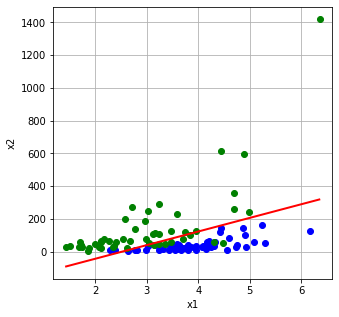

In [11]:
plotData(x_val_LR,y_val_LR,model.theta,1)

In [12]:
error = mse(y_pred_LR,y_val_LR)
print("Error of Linear regression is {}".format(error))

Error of Linear regression is 0.07839112223575706


## c. GDA

### Problem
\begin{align}
p(y) = \phi^{y}(1-\phi)^{(1-y)}\\
p(x|y=0) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}exp(-(x-\mu_{0})^{T}\Sigma^{-1}(x-\mu_{0}))\\
p(x|y=1) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}exp(-(x-\mu_{1})^{T}\Sigma^{-1}(x-\mu_{1}))\\
Show: p(y=1|x;\phi,\mu_0,\mu_1,\Sigma) = \frac{1}{1+exp(-(\theta^{T}x + \theta_0))}\\
where, \theta \in R^n \text{, and } \theta_0 \in R\\
\end{align}
### Prove
\begin{align}
p(y=1|x) = \frac{p(x|y=1)p(y=1)}{p(x)} = \frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)+p(x|y=1)p(y=1)} = \frac{1}{1 + \frac{p(x|y=0)p(y=0)}{p(x|y=1)p(y=1)}}\\
\frac{p(x|y=0)p(y=0)}{p(x|y=1)p(y=1)} =  \frac{exp(-\frac{1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0))}{exp(-\frac{1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1))}\frac{1-\phi}{\phi} = exp(-\frac{1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0) + \frac{1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1) log(\frac{1-\phi}{\phi})) \\= exp(-\frac{1}{2}(\mu_0+\mu_1)^T\Sigma^{-1}(\mu_0+\mu_1)+log(\frac{1-\phi}{\phi}) + (\mu_0-\mu_1)\Sigma^{-1}x)\\
\text{Thus, } \theta_0 = -\frac{1}{2}(\mu_0+\mu_1)^T\Sigma^{-1}(\mu_0+\mu_1)+log(\frac{1-\phi}{\phi})\text{, and } \theta = (\mu_0-\mu_1)\Sigma^{-1}\\
\end{align}

## d. GDA

### Problem
\begin{align}
l(\phi, \mu_0, \mu_1, \Sigma) = log(\prod_{i=1}^m p(x^{(i)},y^{(i)};\phi,\mu_0,\mu_1,\Sigma) = log(\prod_{i=1}^m p(x^{(i)}|y^{(i)};\mu_0,\mu_1,\Sigma)p(y^{(i)};\phi))\\ 
= \prod_{i=1}^m (\frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}exp(-\frac{1}{2}(x^{(i)}-\mu_k)^{T}\Sigma^{-1}(x^{(i)}-\mu_k))\phi^{y^{(i)}}(1-\phi)^{1-y^{(i)}})\\
= \sum_{i=1}^m (-\frac{1}{2}log(2\pi)-\frac{1}{2}log(|\Sigma|)-\frac{1}{2}(x^{(i)}-\mu_k)^{T}\Sigma^{-1}(x^{(i)}-\mu_k)+y^{(i)}log(\phi)+(1-y^{(i)})log(\phi))
\end{align}

### Prove phi
\begin{align}
\frac{\partial l(\phi,\mu_k,\Sigma)}{\partial \phi} = 0\\
\sum_{i=1}^m (\frac{y^{(i)}}{\phi} - \frac{1-y^{(i)}}{1-\phi}) = 0\\
\sum_{i=1}^m (y^{(i)} - y^{(i)}\phi -phi +y^{(i)}\phi) = 0\\
\sum_{i=1}^m (y^{(i)} + \phi) = 0\\
\sum_{i=1}^m y^{(i)} = m\phi\\
\phi = \frac{\sum_{i=1}^m y^{(i)}}{m}\\
\phi = \frac{\sum_{i=1}^m 1(y^{(i)} = 1)}{m}\\
\end{align}

### Prove average
\begin{align}
\frac{\partial}{\partial \mu_k}l(\phi,\mu_k,\Sigma) = 0\\
\frac{\partial}{\partial \mu_k}(\sum_{i=1}^m (-\frac{1}{2}(x^{(i)} - \mu_k)^T\Sigma^{-1}(x^{(i)} - \mu_k))) = 0\\
where, \frac{\partial\alpha^TA\alpha}{\partial\alpha} = 2\alpha^TA\\
where, \alpha = (x^{(i)} - \mu_k)\\
\frac{\partial l}{\partial \mu_k} = \frac{\partial l}{\partial \alpha}\frac{\partial \alpha}{\partial \mu_k}\\
\frac{\partial \alpha}{\partial \mu_k} = 1(y^{(i)} = k)\\
-\frac{1}{2}2\sum_{i=1}^m((x^{(i)} - \mu_k)^T\Sigma^{-1}\frac{\partial \alpha}{\partial \mu_k})=0\\
\sum_{i=1}^m x^{(i)}\frac{\partial \alpha}{\partial \mu_k} - \sum_{i=1}^m \mu_k\frac{\partial \alpha}{\partial \mu_k} = 0\\
Thus, \mu_k = \frac{\sum_{i=1}^m x^{(i)}1(y^{(i)}=k)}{\sum_{i=1}^m 1(y^{(i)}=k)}\\
\mu_k = 
\begin{cases}
\mu_1 &\text{if k=1}\\
\mu_2 &\text{else if k=2}\\
\end{cases}\\
\end{align}

### Prove Sigma
\begin{align}
\frac{\partial}{\partial \Sigma} l(\phi, \mu_k, \Sigma) = 0\\
\frac{\partial}{\partial \Sigma}\sum_{i=1}^m(-\frac{1}{2}log(|\Sigma|) -\frac{1}{2}(x^{(i)} - \mu_k) \Sigma^{-1}(x^{(i)} - \mu_k)) = 0\\
where, \frac{\partial log(|x|)}{\partial x} = x^{-T}, \frac{\partial\alpha^{T}x^{-1}\beta}{\partial x} = -x^{-T}\alpha^T\beta x^{-T}\\
\sum_{i=1}^m(-\frac{1}{2}\Sigma^{-T}+\frac{1}{2}\Sigma^{-T}(x^{(i)} - \mu_k)^T(x^{(i)} - \mu_k)\Sigma^{-T}) = 0\\
\sum_{i=1}^m(-1 + \Sigma^{-T}(x^{(i)} - \mu_k)(x^{(i)} - \mu_k)) = 0\\
m = \sum_{i=1}^m(\Sigma^{-T}(x^{(i)} - \mu_k)^T(x^{(i)} - \mu_k))\\
\Sigma = \frac{\sum_{i=1}^m (x^{(i)} - \mu_k)^T(x^{(i)} - \mu_k)}{m}\\
\end{align}

## e.GDA(Code)

In [13]:
class GDA:
    def fit(self,x,y):
        m,n = x.shape
        # Calculate phi, mu_0, mu_1, Cov
        phi = (y==1).sum()/m
        mu_0 = x[y==0].sum(axis=0) / (y==0).sum()
        mu_1 = x[y==1].sum(axis=0) / (y==1).sum()
        diff = x.copy()
        diff[y==0] -= mu_0
        diff[y==1] -= mu_1
        cov = (1/m) * diff.T.dot(diff)
        # Updata theta
        cov_inv = np.linalg.inv(cov)
        theta = cov_inv.dot(mu_1-mu_0)
        theta0 = (1/2)*(mu_0.T.dot(cov_inv).dot(mu_0) - mu_1.T.dot(cov_inv).dot(mu_1)) - np.log((1 - phi)/phi)
        theta0 = np.array(theta0)
        theta = np.hstack([theta0,theta])
        self.theta = theta
        
    def predict(self,x):
        sigmoid = lambda z: 1 / (1+ np.exp(-z))
        x = add_intercept(x)
        probs = sigmoid(x.dot(self.theta))
        preds = (probs>=0.5).astype(np.int)
        return preds

In [14]:
train_GDA1 = 'data/ds1_train.csv'
valid_GDA1 = 'data/ds1_valid.csv'
train_GDA2 = 'data/ds2_train.csv'
valid_GDA2 = 'data/ds2_valid.csv'

In [15]:
x_train_GDA1,y_train_GDA1 = openData(train_GDA1)
x_val_GDA1,y_val_GDA1 = openData(valid_GDA1)
x_train_GDA2,y_train_GDA2 = openData(train_GDA2)
x_val_GDA2,y_val_GDA2 = openData(valid_GDA2)

In [16]:
modelGDA1 = GDA()
modelGDA1.fit(x_train_GDA1,y_train_GDA1)
modelGDA2 = GDA()
modelGDA2.fit(x_train_GDA2,y_train_GDA2)

In [17]:
y_pred_GDA1 = modelGDA1.predict(x_val_GDA1)

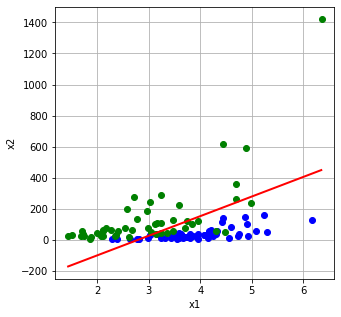

In [18]:
plotData(x_val_GDA1,y_val_GDA1,modelGDA1.theta,1)

In [19]:
error1 = mse(y_pred_GDA1,y_val_GDA1)
print("Error of Linear regression is {}".format(error1))

Error of Linear regression is 0.17


In [20]:
y_pred_GDA2 = modelGDA2.predict(x_val_GDA2)

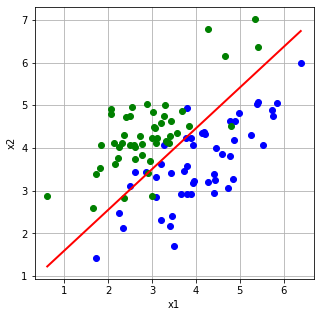

In [21]:
plotData(x_val_GDA2,y_val_GDA2,modelGDA2.theta,1)

In [22]:
error2 = mse(y_pred_GDA2,y_val_GDA2)
print("Error of Linear regression is {}".format(error2))

Error of Linear regression is 0.09


# 2. Incomplete, Positive-Only Labels

## a.

### problem
\begin{align}
p(y^{(i)}=1|t^{(i)}=1,x^{(i)}) = p(y^{(i)}=1|t^{(i)}=1)\\
p(t^{(i)}=1|x^{(i)}) = p(y{(i)}=1|x^{(i)})/\alpha\\
Get, \alpha\\
\end{align}
### prove
\begin{align}
p(y{(i)}=1|x^{(i)}) = p(y^{(i)}=1|t^{(i)}=1,x^{(i)})p(t^{(i)}=1|x^{(i)}) = p(y^{(i)}=1|t^{(i)}=1)p(t^{(i)}=1|x^{(i)})\\
Thus, \alpha = p(y^{(i)}=1|t^{(i)})\\
\end{align}

## b.

### Problem
\begin{align}
h(x^{(i)}) = p(y^{(i)}=1|x^{(i)})\\
show, h(x^{(i)}) = \alpha, x^{(i)}\in V_{+}\\
assume, p(t^{(i)}=1|x^{(i)})=1, x^{(i)}\in V_{+}\\
\end{align}
### Solve
\begin{align}
h(x^{(i)}) = p(y^{(i)}=1|x^{(i)})= p(t^{(i)}=1|x^{(i)})\alpha = \alpha\\
\end{align}

## c. Trained by t

In [23]:
train_pr2 = 'data/ds3_train.csv'
valid_pr2 = 'data/ds3_valid.csv'
test_pr2='data/ds3_test.csv'

In [24]:
t_train_pr2,x_train_pr2,y_train_pr2 = openData(train_pr2,intercept=True)
t_val_pr2,x_val_pr2,y_val_pr2 = openData(valid_pr2,intercept=True)
t_test_pr2,x_test_pr2,y_test_pr2 = openData(test_pr2,intercept=True)

In [25]:
model_pr2t = LogisticRegression(eps=1e-5)
model_pr2t.fit(x_train_pr2,t_train_pr2)

In [26]:
t_pred_pr2t = model_pr2t.predict(x_val_pr2)

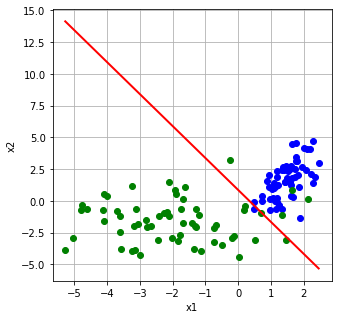

In [27]:
plotData(x_val_pr2,t_val_pr2,model_pr2t.theta,1)

In [28]:
error = mse(t_pred_pr2t,t_val_pr2)
print("Error of Linear regression is {}".format(error))

Error of Linear regression is 0.03855695308985676


## d. Trained by y

In [29]:
model_pr2y = LogisticRegression(eps=1e-5)
model_pr2y.fit(x_train_pr2,y_train_pr2)

In [30]:
t_pred_pr2y = model.predict(x_val_pr2)

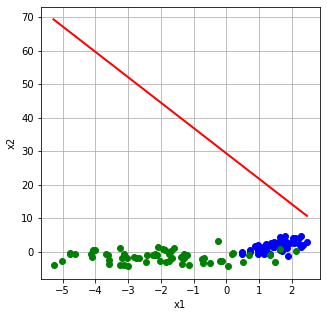

In [31]:
plotData(x_val_pr2,t_val_pr2,model_pr2y.theta,1)

In [32]:
error = mse(t_pred_pr2y,t_val_pr2)
print("Error of Linear regression is {}".format(error))

Error of Linear regression is 0.4102691150439857


## e. Correction

In [33]:
model_pr2C = LogisticRegression(eps=1e-5)
model_pr2C.fit(x_train_pr2,y_train_pr2)

y_pred = model_pr2C.predict(x_val_pr2)

In [34]:
alpha = y_pred[y_val_pr2 == 1].sum() / (y_val_pr2 == 1).sum()

In [35]:
correction = 1 + (np.log(2 / alpha - 1) / model_pr2C.theta[0])

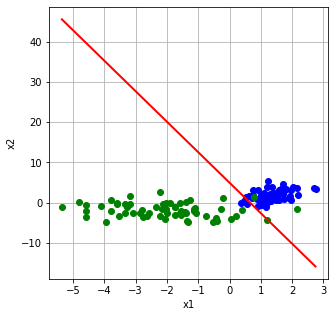

In [36]:
plotData(x_test_pr2,t_test_pr2,model_pr2C.theta,correction)

# 3. Poisson regression

## a. exponential family

\begin{align}
p(y;\lambda) = \frac{e^{-\lambda}\lambda^y}{y!}\\
exp(log(\frac{e^{-\lambda}\lambda^y}{y!}))\\
exp(-\lambda log(e) + ylog(\lambda)-log(y!))\\
\frac{1}{y!}exp((log(\lambda))y -\lambda)\\
b(y) = \frac{1}{y!}\\
\eta^T = log(\lambda)\\
T(y) = y\\
a(\eta) = \lambda = e^{\eta}\\
\end{align}

## b. Canonical response function for poisson

\begin{align}
h_{\theta}(x) = E[y|x;\theta] = \lambda = e^\eta = e^{\theta^{T}x}\\
where, \eta = \theta^{T}x\\
\end{align}

## c. GLM of poisson

\begin{align}
L(\theta) = p(y;\lambda) = \frac{e^{-\lambda}\lambda^y}{y!}\\
l(\theta) = \sum_{i=1}^m log(L(\theta)) = \sum_{i=1}^m(-log(y^{(i)}!) + y^{(i)}log(\lambda) - \lambda)\\
where, e^\eta = e^{\theta^T x}\\
l(\theta) = \sum_{i=1}^m(-log(y^{(i)}!)+y^{(i)}log(e^{\theta^{T}x^{(i)}})-e^{\theta^{T}x^{(i)}})\\
l(\theta) = \sum_{i=1}^m(-log(y^{(i)}!)+y^{(i)}\theta^{T}x^{(i)}-e^{\theta^{T}x^{(i)}})\\
\frac{\partial l(\theta)}{\partial \theta_j} = \sum_{i=1}^m(y^{(i)}x_j^{(i)} - x_j^{(i)}e^{\theta^{T}x^{(i)}})\\
\frac{\partial l(\theta)}{\partial \theta_j} =\sum_{i=1}^m(y^{(i)} - e^{\theta^{T}x^{(i)}})x_j^{(i)}\\
\frac{\partial l(\theta)}{\partial \theta_j} =\sum_{i=1}^m(y^{(i)} - g(\theta^{T}x^{(i)}))x_j^{(i)}\\
\theta := \theta + \alpha\frac{\partial l(\theta)}{\partial \theta_j} = \theta + \alpha\sum_{i=1}^m(y^{(i)} - g(\theta^{T}x^{(i)}))x_j^{(i)}\\
\end{align}

## d. Poisson regression (coding)

In [37]:
class PoissongRegression:
    def __init__(self,max_iter,alpha,eps):
        self.theta = None
        self.max_iter = max_iter
        self.alpha = alpha
        self.eps = eps
        
    def fit(self,x,y):
        m,n = x.shape
        if self.theta ==None:
            self.theta = np.zeros(n)
        g = lambda x: np.exp(x)
        for i in range(self.max_iter):
            theta = self.theta
            grad_logLike = (1/m)*(y-g(x.dot(theta))).dot(x)
            self.theta = theta + self.alpha*grad_logLike
            if(np.linalg.norm(self.theta-theta,ord=1)<self.eps):
                break
        
    def predict(self,x):
        g = lambda z:np.exp(z)
        return g(x.dot(self.theta))

In [38]:
train_pr3 = 'data/ds4_train.csv'
valid_pr3 = 'data/ds4_valid.csv'

In [39]:
x_train_pr3,y_train_pr3 = openData(train_pr3)
x_val_pr3,y_val_pr3 = openData(valid_pr3)

In [40]:
modelPoi = PoissongRegression(1000000, 1e-7, 1e-5)
modelPoi.fit(x_train_pr3, y_train_pr3)

In [41]:
y_pred_poi = modelPoi.predict(x_val_pr3)

In [42]:
error = mse(y_pred_poi,y_val_pr3)
print("Error of Linear regression is {}".format(error))

Error of Linear regression is 23485736961257.734


# 4. Convexity of Generalized Linear Models

## a. Expectation

### Problem
\begin{align}
p(y;\eta) = b(y)exp(\eta y - a(\eta))\\
where, \frac{\partial}{\partial \eta}\int p(y;\eta)dy = \int \frac{\partial}{\partial \eta}p(y;\eta)dy\\
E[Y|X;\theta] = ?\\
\end{align}
### Prove
\begin{align}
\frac{\partial}{\partial \eta}\int p(y;\eta)dy = \int \frac{\partial}{\partial \eta}p(y;\eta)dy = 0\\
\int \frac{\partial}{\partial \eta}(b(y)exp(\eta y - a(\eta)))dy = 0\\
\int b(y)exp(\eta y - a(\eta))(y-a'(\eta))dy = 0\\
\int y(b(y))exp(\eta y - a(\eta))dy - \int a'(\eta)b(y)exp(\eta y - a(\eta))dy = 0\\
\int yp(y;\eta)dy - a'(\eta)\int p(y;\eta)dy = 0\\
where, \int yp(y;\eta)dy = E[y;\eta]\\
where, \int p(y;\eta)dy = 1\\
E[y;\eta] - a'(\eta) = 0\\
Thus, E[y;\eta] = a'(\eta)\\
\end{align}

## b. Variation

### Problem
\begin{align}
Var(Y|X;\theta) = ?\\
\end{align}
### Prove
\begin{align}
\int \frac{\partial^2}{\partial^2\eta} p(y;\eta)dy = \frac{\partial}{\partial \eta}(\int y(b(y))exp(\eta y - a(\eta))dy - \int a'(\eta)b(y)exp(\eta y - a(\eta))dy) = 0\\
\int yb(y)exp(\eta y - a(\eta))(y-a'(\eta))dy - \int a''(\eta)b(y)exp(\eta y - a(\eta))dy - \int a'(\eta)b(y)exp(\eta y - a(\eta))(y-a'(\eta))dy = 0\\
\int y^{2}b(y)epx(\eta y - a(\eta))dy - \int yb(y)a'(\eta)exp(\eta y - a(\eta))dy - \int a''(\eta)b(y)exp(\eta y - a(\eta))dy + \int y a'(\eta)b(\eta)exp(\eta y - a(\eta))dy - \int (a'(\eta))^{2} b(\eta) exp(\eta y - a(\eta))dy = 0\\
\int y^{2}p(y|\eta)dy - a'(\eta)^2\int p(y|\eta)dy - a''(\eta)\int p(y|\eta)dy = 0\\
where, y^{2}p(y|\eta)dy = E[y^2;\eta]\\
whre, E[y^2;\eta] - E[y;\eta] = Var(y;\eta)\\
Var(y;\eta) - a''(\eta) = 0\\
Thus, Var(y;\eta) = a''(\eta)\\
\end{align}

## c. Hessian of loss function 

### Loss function
\begin{align}
p(y;\eta) = b(y)exp(\eta y - a(\eta))\\
l(\theta) = -\sum_{i=1}^m log(p(y;\eta) = -\sum_{i=1}^m(log(b(y^{(i)})) + y^{(i)}\theta^T x^{(i)} - a(\theta^T x^{(i)}))\\
where, \eta = \theta^T x^{(i)}\\
\end{align}
### Hessian
\begin{align}
H_{kl} = \frac{\partial l(\theta)}{\partial\theta_k\partial\theta_l} = \sum_{i=1}^m a''(\theta^T x^{(i)})x_k^{(i)}x_l^{(i)}\\
\end{align}
### Semi Positive Definite
\begin{align}
z^{T}Hz = \sum_{k=1}^n\sum_{l=1}^n z_{k}H_{kl}z_{l} = \sum_{k=1}^n\sum_{l=1}^n z_k(\sum_{i=1}^m a''(\theta^T x^{(i)})x_k^{(i)}x_l^{(i)})z_l = \sum_{i=1}^m a''(\theta^T x^{(i)})\sum_{k=1}^n\sum_{l=1}^n z_{k}x_{k}^{(i)}x_{l}^{(i)}z_l\\
where, a''(\theta^T x^{(i)}) = Var(y|x) \geq 0\\
where, \sum_{k=1}^n\sum_{l=1}^n z_{k}x_{k}^{(i)}x_{l}^{(i)}z_l = (x^{(i)}z)^2 \geq 0\\
Thus, z^{T}Hz \geq 0\\
\end{align}

# 5. Locally weighted linear regression

## a.

### Problem
\begin{align}
J(\theta) = \frac{1}{2}\sum_{i=1}^m w^{(i)}(\theta^{T}x^{(i)} - y^{(i)})^2\\
\end{align}
### i
\begin{align}
J(\theta) = \sum_{i=1}^m (\theta^{T}x_{(i)} - y^{(i)})(\frac{1}{2}w^{(i)})(\theta^{T}x_{(i)} - y^{(i)}) = \sum_{i=1}^m (x\theta - y)_{i}^T(\frac{1}{2}w^{(i)})(x\theta - y)_{i}\\
W_{ij} = 
\begin{cases}
\frac{1}{2}w^{(i)} &\text{if i = j}\\
0 &\text{otherwise}\\
\end{cases}\\
J(\theta) = \sum_{i,j=1}^m (x\theta - y)_{i}^T W_{ij}(x\theta - y)_{j}\\
J(\theta) = (X\theta - y)^T W(X\theta - y)\\
\end{align}
### ii
\begin{align}
\frac{\partial}{\partial \theta}J(\theta) = \frac{\partial}{\partial \theta}(\theta^{T}x^{T}WX\theta - 2\theta^{T}x^{T}wy+y^TWy) = 2X^TWX\theta - 2X^TWy\\
\frac{\partial}{\partial\theta}(J(\theta)) = 0\\
2X^TWX\theta - 2X^TWy = 0\\
Thus, \theta = (X^TWX)^{-1}X^TWy\\
\end{align}
### iii
\begin{align}
l(\theta) = \sum_{i=1}^m log(p(y^{(i)}|x^{(i)};\theta)) = \sum_{i=1}^m (-log(\sqrt{2}\pi) - log(\sigma^{(i)}) - \frac{(y^{(i)}-\theta^Tx^{(i)})^2}{2(\sigma^{(i)})^2})\\
J(\theta) = \sum_{i=1}^m \frac{(y^{(i)}-\theta^Tx^{(i)})^2}{2(\sigma^{(i)})^2}\\
Thus, w^{(i)} = \frac{1}{(\sigma^{(i)})^2}\\
\end{align}

## b. Weighted linear regression (coding)

In [43]:
class LocallyWeightedLinearRegression:
    def __init__(self,tau):
        super(LocallyWeightedLinearRegression,self).__init__()
        self.tau = tau
        self.x = None
        self.y = None
    
    def fit(self,x,y):
        self.x = x
        self.y = y
    
    def predict(self,x):
        m,n = x.shape
        g = lambda x: np.exp(-x**2/(2*self.tau**2))
        w = g(np.linalg.norm(self.x[None] - x[:,None],axis=2))
        y_pred = np.zeros(m)
        for i,W in enumerate(w):
            W = np.diag(W)
            theta = np.linalg.inv(self.x.T.dot(W).dot(self.x)).dot(self.x.T).dot(W).dot(self.y)
            y_pred[i] = x[i].dot(theta)
        return y_pred
        

In [44]:
train_pr5 = 'data/ds5_train.csv'
valid_pr5 = 'data/ds5_valid.csv'
test_pr5 = 'data/ds5_test.csv'

In [45]:
x_train_pr5,y_train_pr5 = openData(train_pr5,intercept=True,prb='5')
x_val_pr5,y_val_pr5 = openData(valid_pr5,intercept=True,prb='5')
x_test_pr5,y_test_pr5 = openData(test_pr5,intercept=True,prb='5')

In [46]:
modelLW = LocallyWeightedLinearRegression(0.5)
modelLW.fit(x_train_pr5,y_train_pr5)

In [47]:
y_pred = modelLW.predict(x_val_pr5)

In [48]:
error = ((y_pred-y_val_pr5)**2).mean()
print("Error of problem5 is {}".format(error))

Error of problem5 is 0.33053126821375256


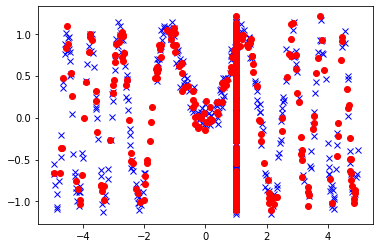

In [49]:
plt.figure()
plt.plot(x_train_pr5,y_train_pr5,'bx')
plt.plot(x_val_pr5,y_val_pr5,'ro')

## c. Different tau

In [50]:
tau_values=[3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

tau: 0.05, mse: 0.012400076150469373
test mse: 0.8889410764429647


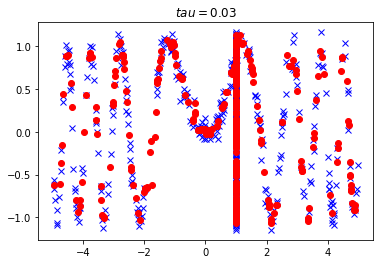

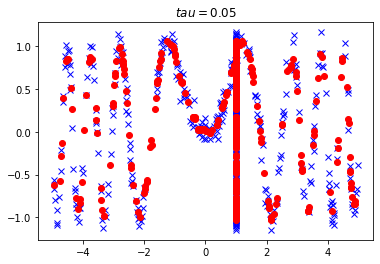

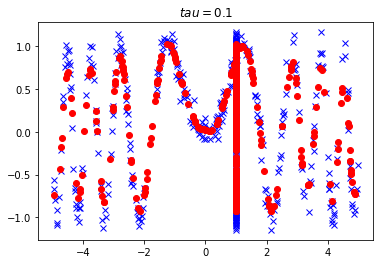

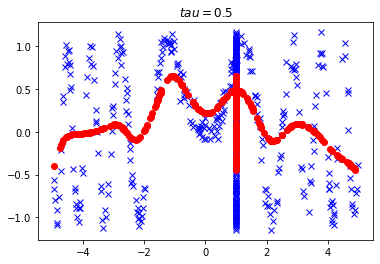

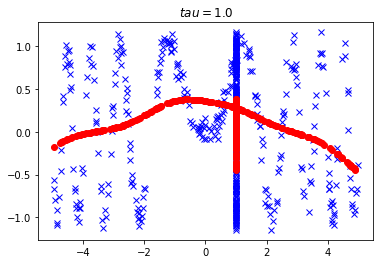

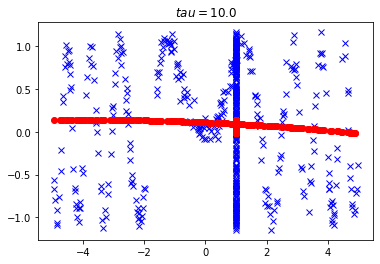

In [53]:
best_tau = None
best_mse = None
for tau in tau_values:
    model_tau = LocallyWeightedLinearRegression(tau)
    model_tau.fit(x_train_pr5,y_train_pr5)
    y_pred = model_tau.predict(x_val_pr5)
    error = mse(y_pred, y_val_pr5)
    plt.figure()
    plt.title('$tau = {}$'.format(tau))
    plt.plot(x_train_pr5, y_train_pr5, 'bx')
    plt.plot(x_val_pr5, y_pred, 'ro')
    if best_mse :
        if error < best_mse:
            best_mse = error
            best_tau = tau
    else:
        best_mse = error
        best_tau = tau
        
print('tau: {}, mse: {}'.format(best_tau, best_mse))
model_tauB = LocallyWeightedLinearRegression(best_tau)
model_tauB.fit(x_train_pr5, y_train_pr5)
# Run on the test set to get the MSE value
y_pred = model_tauB.predict(x_test_pr5)
error = ((y_val_pr5 - y_pred) ** 2).mean()
print('test mse: {}'.format(error))